In [ ]:
!python --version

Python 3.10.12


In [ ]:
pip install difflib

ERROR: Could not find a version that satisfies the requirement difflib (from versions: none)
ERROR: No matching distribution found for difflib


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from difflib import get_close_matches

# بارگذاری مدل زبان (ParsBERT)
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-zwnj-base")
model = AutoModelForMaskedLM.from_pretrained("HooshvareLab/bert-fa-zwnj-base")

# الگوریتم تصحیح غلط‌های غیرواقعی
def correct_non_word_error(word, dictionary):
    matches = get_close_matches(word, dictionary, n=1, cutoff=0.8)
    return matches[0] if matches else word

# الگوریتم تصحیح غلط‌های واقعی برای کلمات خاص
def correct_real_word_error(word, sentence):
    # جایگزینی کلمه با [MASK]
    masked_sentence = sentence.replace(word, "[MASK]", 1)
    tokens = tokenizer(masked_sentence, return_tensors="pt")
    outputs = model(**tokens)
    mask_token_index = (tokens.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()
    predicted_token_id = outputs.logits[0, mask_token_index].argmax(dim=-1)
    corrected_word = tokenizer.decode([predicted_token_id]).strip()
    return corrected_word

# تست
dictionary = ["کتاب", "خانه", "ماشین", "مدرسه"]
text = "مدررسه رفت"
words = text.split()

# ابتدا تصحیح غلط‌های غیرواقعی
corrected_words = [correct_non_word_error(word, dictionary) for word in words]

# سپس تصحیح غلط‌های واقعی
final_words = []
for word in corrected_words:
    if word not in dictionary:  # اگر هنوز مشکوک است، بررسی با مدل
        corrected_word = correct_real_word_error(word, text)
        final_words.append(corrected_word)
    else:
        final_words.append(word)

# ترکیب کلمات نهایی
final_corrected_sentence = " ".join(final_words)

print("متن تصحیح شده:", final_corrected_sentence)


متن تصحیح شده: مدرسه .


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def min_max(data):
    # Initialize MinMaxScaler with feature range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Reshape data if it's a 1D array to make it compatible with the scaler
    data_reshaped = data.reshape(-1, 1)

    # Fit and transform the data
    y_norm = scaler.fit_transform(data_reshaped)
    y_norm = np.clip(y_norm, -1, 1)
    # Reshape back to original shape if needed
    return y_norm.flatten()

In [ ]:
def create_batches(df,window_size, stride=1):
  batches = []
  for i in range(0, len(df) - window_size + 1, stride):
    batch = df[i : i + window_size]
    batches.append(batch)
  return batches

In [ ]:
def create_GASF2(batches):
  GASF_list=[]

  for batch in batches:
    GASF = calculate_GASF2(batch)
    scaler = MinMaxScaler()
    GASF_normal = scaler.fit_transform(GASF)
    GASF_normal = np.clip(GASF_normal, 0, 1)
    GASF_list.append(GASF_normal)

  return GASF_list

In [ ]:
def calculate_GASF2(batch):
    # استخراج ستون I3_A از batch
    y = batch['I3_A'].to_numpy()

    # نرمال‌سازی داده‌ها
    y_norm = min_max(y)

    # محاسبه زوایا با استفاده از arccos
    angles_ynorm = np.arccos(y_norm)

    # محاسبه Gramian Angular Summation Field (GASF)
    GASF_ynorm = np.cos(angles_ynorm[:, None] + angles_ynorm[None, :])

    return GASF_ynorm


# Load data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/WashingMachine_PhaseCount_3_geq_2017-10-23_lt_2017-10-30.csv')

# Preprocessing

In [ ]:
my_data = data[['SensorDateTime', 'I3_A']]

In [ ]:
my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
my_data['SensorDateTime_numeric'] = my_data['SensorDateTime'].map(pd.Timestamp.timestamp)  # تبدیل به عدد

<ipython-input-33-c99ef3356e84>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
<ipython-input-33-c99ef3356e84>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
<ipython-input-33-c99ef3356e84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [ ]:
batches = create_batches(my_data,window_size=24,stride=5)
GASF_list2 = create_GASF2(batches)

In [ ]:
import tensorflow as tf
import numpy as np

# داده اولیه
data = np.array(GASF_list2[0], dtype=np.float32)  # داده با ابعاد 24x24x1
data = data.reshape((24, 24, 1))

# تبدیل به Tensor
data_tensor = tf.convert_to_tensor(data)

# ریسایز به 12x12x1
resized_12x12 = tf.image.resize(data_tensor, [12, 12], method='area')

# ریسایز به 8x8x1
resized_8x8 = tf.image.resize(data_tensor, [8, 8], method='area')

# تبدیل به numpy برای مشاهده ابعاد
resized_12x12 = resized_12x12.numpy()
resized_8x8 = resized_8x8.numpy()

# نمایش ابعاد
print("Original shape:", data.shape)
print("Resized to 12x12x1:", resized_12x12.shape)
print("Resized to 8x8x1:", resized_8x8.shape)


Original shape: (24, 24, 1)
Resized to 12x12x1: (12, 12, 1)
Resized to 8x8x1: (8, 8, 1)


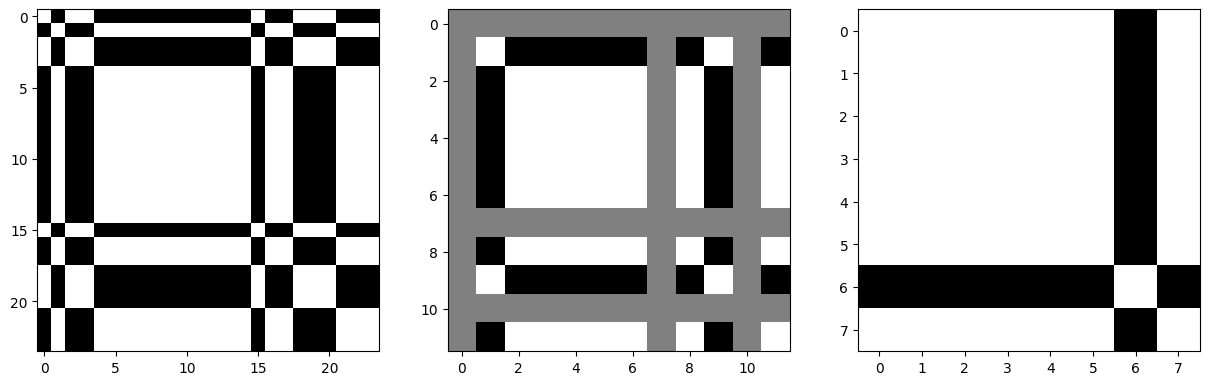

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(data_tensor, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(resized_12x12, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(resized_8x8, cmap='gray')

plt.show()

# Prepare GASFs as input

In [ ]:
from sklearn.model_selection import train_test_split
def train_test_set_improved(window_size,stride):

  batches = create_batches(my_data,window_size=window_size,stride=stride)

  # give these for prediction
  train_data, test_data = train_test_split(batches, test_size=0.2, random_state=42)

  train_gasf = create_GASF2(train_data)
  test_gasf = create_GASF2(test_data)

  # give these to the network
  x_train_gasf = np.array(train_gasf)
  x_test_gasf = np.array(test_gasf)

  x_train_gasf = x_train_gasf.reshape((-1, 128, 128, 1))
  x_test_gasf = x_test_gasf.reshape((-1, 128, 128, 1))

  return x_train_gasf, x_test_gasf, train_data, test_data

In [ ]:
from sklearn.model_selection import train_test_split
def train_test_set_improved(window_size,stride):

  batches = create_batches(my_data,window_size=window_size,stride=stride)

  # give these for prediction
  train_data, test_data = train_test_split(batches, test_size=0.2, random_state=42)

  train_gasf = create_GASF2(train_data)
  test_gasf = create_GASF2(test_data)

  # give these to the network
  x_train_gasf = np.array(train_gasf)
  x_test_gasf = np.array(test_gasf)

  x_train_gasf = x_train_gasf.reshape((-1, 24, 24, 1))
  x_test_gasf = x_test_gasf.reshape((-1, 24, 24, 1))

  return x_train_gasf, x_test_gasf, train_data, test_data

# Visualize GASFs

In [ ]:
x_train_gasf, x_test_gasf, _, _ = train_test_set_improved(window_size=128,stride=5)

In [ ]:
x_test_gasf.shape

In [ ]:
GASF_y1 = x_train_gasf[29]

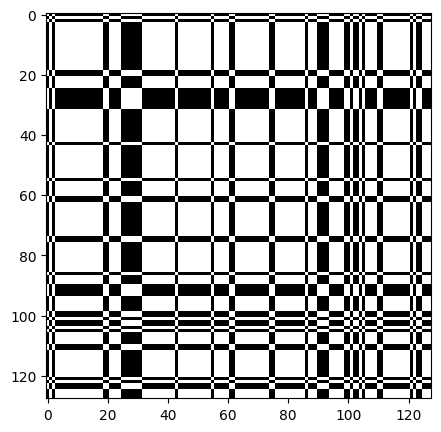

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(GASF_y1, cmap='gray')

plt.show()

# VAE

## Functions

In [ ]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
class ResizeLayer(layers.Layer):
    def __init__(self, new_height, new_width):
        super(ResizeLayer, self).__init__()
        self.new_height = new_height
        self.new_width = new_width

    def call(self, inputs):
        return tf.image.resize(inputs, [self.new_height, self.new_width], method='bilinear')

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        # Pass the inputs through the encoder and then the decoder
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z)
        reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }




In [ ]:
def train_vae(x_train, x_test,encoder, decoder, model_path):

  vae = VAE(encoder, decoder)
  vae.compile(optimizer=keras.optimizers.Adam())

  checkpoint_filepath = model_path
  model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      # save_weights_only=True,
      monitor="val_loss",   # scale
      mode="min",           # best model with minimum val_loss
      save_best_only=True
  )
  early_stopping_callback = keras.callbacks.EarlyStopping(
      monitor='val_loss',   # scale
      # min_delta=5,      # minimum change to continue training
      patience=15,          # stop if it did not change after 30 epochs
      verbose=1,            # display info with some details
      mode='min',          # scale should decrease or increase
      restore_best_weights=True, # restore the best weights
  )
  tensorboard_callback = keras.callbacks.TensorBoard(
      log_dir="logs",
      histogram_freq=1,
  )
  # vae.fit(x_train, epochs=300, batch_size=32, validation_data=x_test , callbacks=[model_checkpoint_callback, early_stopping_callback, tensorboard_callback])
  return vae


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_combined(vae, x_test_gasf,test_data, latent_dim, n=30):

    # Select n samples
    x_sample = x_test_gasf[:n]
    # Use the VAE to reconstruct the inputs
    reconstructed = vae(x_sample, training=False)
    # Generate random latent vectors for new images
    z_random = tf.random.normal(shape=(n, latent_dim))
    generated_samples = vae.decoder(z_random, training=False)

    fig, axs = plt.subplots(2, n, figsize=(15, 6))
    for i in range(n):

        # Original image
        axs[0, i].imshow(x_sample[i].squeeze(), cmap='gray')
        # axs[0, i].set_title("Original")
        axs[0, i].axis('off')

        # Reconstructed image
        axs[1, i].imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        # axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')

        # Generated random image
        # axs[2, i].imshow(generated_samples[i].numpy().squeeze(), cmap='gray')
        # # axs[2, i].set_title("Generated")
        # axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_reconstructed(vae, x_test_gasf,test_data, latent_dim, n=30):
    # Select n samples
    x_sample = x_test_gasf[:n]
    # Use the VAE to reconstruct the inputs
    reconstructed = vae(x_sample, training=False)
    fig, axs = plt.subplots(1, n, figsize=(15, 10))
    for i in range(n):
        axs[i].imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


## inoutsize = (24,24)

### Encoder and Decoder

In [ ]:
def encoder(latent_dim):

    encoder_inputs = keras.Input(shape=(24, 24, 1))
    x = encoder_inputs

    # Stream for original scale
    x1 = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
    x1 = layers.Conv2D(8, 3, activation="relu")(x1)
    x1 = layers.MaxPooling2D()(x1)
    x1 = layers.Conv2D(16, 3, activation="relu")(x1)
    x1 = layers.MaxPooling2D()(x1)
    x1 = layers.Conv2D(32, 3, activation="relu")(x1)

    # Stream for half scale
    scale_factor = 0.5
    size = int(24 * scale_factor)  # Using fixed size as input shape is known

    resize_half = ResizeLayer(size, size)  # Define resizing layer
    x2 = resize_half(x)
    x2 = layers.Conv2D(8, 3, activation="relu")(x2)
    x2 = layers.Conv2D(16, 3, activation="relu")(x2)
    x2 = layers.MaxPooling2D()(x2)
    x2 = layers.Conv2D(32, 3, activation="relu")(x2)

    # Stream for quarter scale
    scale_factor = 0.25
    size = int(24 * scale_factor)  # Using fixed size as input shape is known
    resize_quarter = ResizeLayer(size, size)  # Define resizing layer
    x3 = resize_quarter(x)
    x3 = layers.Conv2D(16, 3, activation="relu")(x3)
    x3 = layers.Conv2D(32, 3, activation="relu")(x3)

    # Combine all streams (x1, x2, x3)
    x = layers.Concatenate(axis=-1)([x1, x2, x3])
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)


    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var,z], name="encoder")
    return encoder

def decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(2*2*64, activation="relu")(latent_inputs)
    x = layers.Reshape((2,2,64))(x)

    x = layers.Conv2DTranspose(64, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(8, 3, activation='relu')(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2DTranspose(8, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(4, 3, activation='relu')(x)



    x = layers.Conv2DTranspose(1, 1, activation='sigmoid')(x)

    decoder_outputs = x
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder

In [ ]:
dec = decoder(60)
dec.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_21                  │ (None, 4, 4, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_22                  │ (None, 6, 6, 32)            │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_23                  │ (None, 8, 8, 16)            │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_24                  │ (None, 10, 10, 8)           │           1,160 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 20, 20, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_25                  │ (None, 22, 22, 8)           │             584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_26                  │ (None, 24, 24, 4)           │             292 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_27                  │ (None, 24, 24, 1)           │               5 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,673 (303.41 KB)

 Trainable params: 77,673 (303.41 KB)

 Non-trainable params: 0 (0.00 B)

## inoutsize = (128,128)

### Encoder and Decoder

In [ ]:
def encoder(latent_dim):

    encoder_inputs = keras.Input(shape=(128, 128, 1))
    x = encoder_inputs

    # Stream for original scale
    x1 = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
    x1 = layers.Conv2D(8, 3, activation="relu")(x1)
    x1 = layers.MaxPooling2D()(x1)
    x1 = layers.Conv2D(16, 3, activation="relu")(x1)
    x1 = layers.MaxPooling2D()(x1)
    x1 = layers.Conv2D(32, 3, activation="relu")(x1)

    # Stream for half scale
    scale_factor = 0.5
    new_height = int(128 * scale_factor)  # Using fixed size as input shape is known
    new_width = int(128 * scale_factor)

    resize_half = ResizeLayer(new_height, new_width)  # Define resizing layer
    x2 = resize_half(x)
    x2 = layers.Conv2D(8, 3, activation="relu")(x2)
    x2 = layers.Conv2D(16, 3, activation="relu")(x2)
    x2 = layers.MaxPooling2D()(x2)
    x2 = layers.Conv2D(32, 3, activation="relu")(x2)

    # Stream for quarter scale
    scale_factor = 0.25
    new_height = int(128 * scale_factor)  # Using fixed size as input shape is known
    new_width = int(128 * scale_factor)

    resize_quarter = ResizeLayer(new_height, new_width)  # Define resizing layer
    x3 = resize_quarter(x)
    x3 = layers.Conv2D(16, 3, activation="relu")(x3)
    x3 = layers.Conv2D(32, 3, activation="relu")(x3)

    # Combine all streams (x1, x2, x3)
    x = layers.Concatenate(axis=-1)([x1, x2, x3])
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.Dense(256)(x)


    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var,z], name="encoder")
    return encoder

def decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(2*2*64, activation="relu")(latent_inputs)
    x = layers.Reshape((2,2,64))(x)

    x = layers.Conv2DTranspose(64, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(8, 3, activation='relu')(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2DTranspose(8, 3, activation='relu')(x)
    x = layers.Conv2DTranspose(4, 3, activation='relu')(x)
    x = layers.UpSampling2D()(x)


    x = layers.Conv2DTranspose(1, 1, activation='sigmoid')(x)

    decoder_outputs = x
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder

In [ ]:
# enc = encoder(60)
# enc.summary()

In [ ]:
dec = decoder(60)
dec.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)          │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_11 (Reshape)                 │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_98                  │ (None, 4, 4, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_99                  │ (None, 6, 6, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_100                 │ (None, 8, 8, 32)            │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_101                 │ (None, 10, 10, 32)          │           9,248 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_31 (UpSampling2D)      │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_102                 │ (None, 22, 22, 32)          │           9,248 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_103                 │ (None, 24, 24, 32)          │           9,248 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_104                 │ (None, 26, 26, 16)          │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_105                 │ (None, 28, 28, 16)          │           2,320 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_106                 │ (None, 30, 30, 8)           │           1,160 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_32 (UpSampling2D)      │ (None, 60, 60, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_107                 │ (None, 62, 62, 8)           │             584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_108                 │ (None, 64, 64, 4)           │             292 │
│ (Conv2DTranspose)                    │                             │              

 Total params: 144,665 (565.10 KB)

 Trainable params: 144,665 (565.10 KB)

 Non-trainable params: 0 (0.00 B)

# Train VAE (Multi-scale CNN)

## d=40

In [ ]:
x_train_gasf, x_test_gasf, _ , test_data = train_test_set_improved(window_size = 24,stride=5)
enc = encoder(40)
dec = decoder(40)
vae_cnn_multiscale_d40_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_multiscale_d40_w24.keras')
vae_cnn_multiscale_d40_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_multiscale_d40_w24.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
'''
    w = 24
    d = 40

    epochs = 300
    patience = 15
    early stop at : 175
    val_loss = 116
'''
vae_cnn_multiscale_d40_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_multiscale_d40_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - kl_loss: 10.8695 - loss: 124.3572 - reconstruction_loss: 113.4877

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - kl_loss: 10.8695 - loss: 124.3582 - reconstruction_loss: 113.4887 - val_kl_loss: 11.1061 - val_loss: 124.6131 - val_reconstruction_loss: 113.5071
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - kl_loss: 11.1361 - loss: 126.7547 - reconstruction_loss: 115.6185 - val_kl_loss: 10.9108 - val_loss: 124.7092 - val_reconstruction_loss: 113.7983
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - kl_loss: 10.7515 - loss: 122.0725 - reconstruction_loss: 111.3210 - val_kl_loss: 10.7218 - val_loss: 125.9019 - val_reconstruction_loss: 115.1801
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - kl_loss: 11.1139 - loss: 125.5868 - reconstruction_loss: 114.4729 - val_kl_loss: 11.0439 - val_loss: 123.0660 - val_reconstruction_loss: 112.0221
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - kl_loss: 10.9724 - loss: 124.1181 - reconstruction_loss: 113.1457 - val_kl_loss: 10.7868 - val_loss: 123.1450 - val_reconstruction_loss: 112.35

In [ ]:
'''
    w = 24
    d = 100

    epochs = 300
    patience = 15
    early stop at : 195
    val_loss = 126
'''
x_train_gasf, x_test_gasf, _ , test_data = train_test_set_improved(window_size = 24,stride=5)
enc = encoder(100)
dec = decoder(100)
vae_cnn_multiscale_d100_w24 = train_vae(x_train_gasf,x_test_gasf,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_multiscale_d100_w24.keras')

Epoch 1/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - kl_loss: 6.2115 - loss: 295.4143 - reconstruction_loss: 289.2029

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


553/553 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - kl_loss: 6.2122 - loss: 295.3427 - reconstruction_loss: 289.1305 - val_kl_loss: 3.3927 - val_loss: 224.5903 - val_reconstruction_loss: 221.1976
Epoch 2/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - kl_loss: 6.0563 - loss: 226.1009 - reconstruction_loss: 220.0446 - val_kl_loss: 3.7775 - val_loss: 215.7272 - val_reconstruction_loss: 211.9497
Epoch 3/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - kl_loss: 5.6220 - loss: 221.0575 - reconstruction_loss: 215.4355 - val_kl_loss: 3.3569 - val_loss: 215.6031 - val_reconstruction_loss: 212.2462
Epoch 4/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - kl_loss: 4.9305 - loss: 217.8373 - reconstruction_loss: 212.9067 - val_kl_loss: 5.0605 - val_loss: 214.0562 - val_reconstruction_loss: 208.9957
Epoch 5/300
553/553 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - kl_loss: 4.6178 - loss: 218.1400 - reconstruction_loss: 213.5221 - val_kl_loss: 7.2262 - val_loss: 206.4411 - val_reconstruction_loss: 199.2149
Epoch 6

##d=100

# Visualize

## d=40

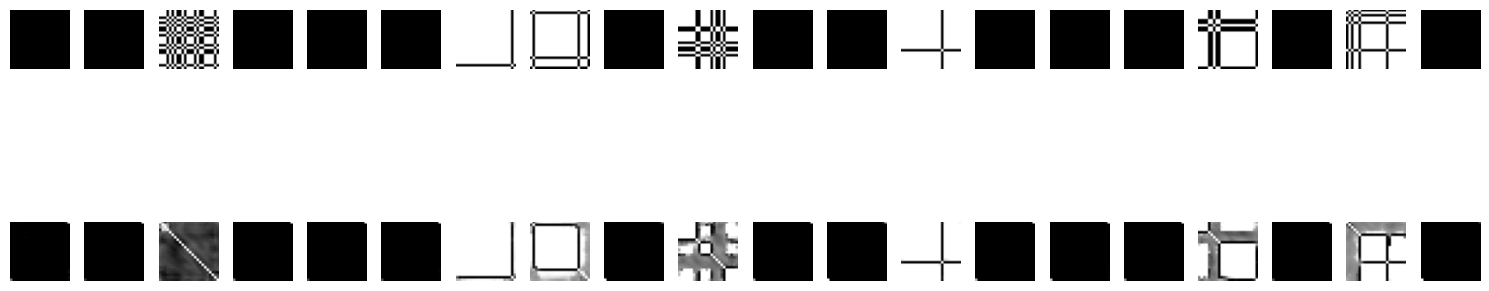

In [ ]:
vae_cnn_multiscale_d40_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_multiscale_d40_w24.keras')
visualize_combined(vae_cnn_multiscale_d40_w24, x_test_gasf,test_data, latent_dim=40, n=20)

## d=100

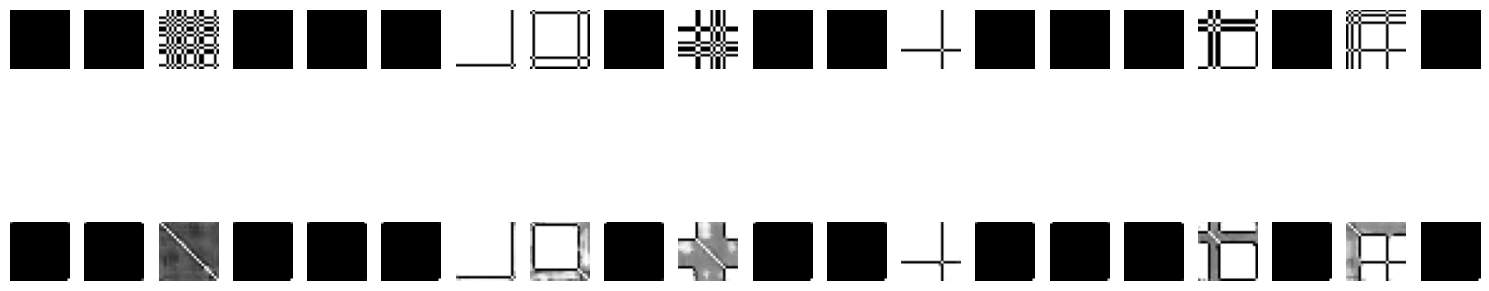

In [ ]:
vae_cnn_multiscale_d100_w24.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/vae_cnn_multiscale_d100_w24.keras')
visualize_combined(vae_cnn_multiscale_d100_w24, x_test_gasf,test_data, latent_dim=100, n=20)